# Data preparation

In [1]:
# For data manipulation 
import pandas as pd
import numpy as np 
import math 
# For visualization 
import matplotlib.pyplot as plt
import seaborn as sns
# For data modelling
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
# For evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# Import data
file_path = "glass_data.csv"
headers_full = ['ID','RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
headers = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
attributes = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
elements = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
glass_df = pd.read_csv(file_path, sep=',', decimal='.', header=None, names=headers_full)

In [3]:
glass_df.head()

,ID,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## Examnine data shape, entry errors and missing values

In [4]:
# Shape of data
glass_df.shape

(214, 11)

In [5]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  Type    214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [6]:
glass_df = glass_df.drop('ID', axis=1)
glass_df.head(5)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


The description indicates that:
- The attributes are all numeric types. There are no data type entry errors.
- The number of instances is 214, which matches the number of attributes in each column. We deduce that there is no missing values in the dataset.


In [7]:
glass_df.Type.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

## Examine impossible values and outliers

From the boxplot, it can be observed that:
- Most of the figures have outliers, except for Magnesium.
- Boxplot figure is not applied well for Barium, so we cannot decide whether it has outliers or not. 
- Apart from Na and K, other elements have an excessive number of outliers.

However, we do not have enough evidence to consider the out of range values as outliers, since it could be a proportion indicating new source of glass. Thus, these outliers should be kept in the dataset.

For the elemental composition, the impossible values can be evaluated via two criteria:
- The weight percentage of the oxides should be >= 0 and < 100. 
- The sum of the weight percentages of the corresponding oxides in a glass composition should not be > 100%. It can be less than 100%, because there might be impurities in the composition. 
For the refractive index, general glass refractive index cannot be negative. 

If a fragment (a row) does not satisfy these criteria, it should be eliminated from the dataset.

In [8]:
# Examine weight percentage of each element if it is out of range (0,100)
out_of_range = ((glass_df[elements] < 0) | (glass_df[elements] >= 100)).any()
out_of_range

Na    False
Mg    False
Al    False
Si    False
K     False
Ca    False
Ba    False
Fe    False
dtype: bool

In [9]:
# Examine the sum of weight percentage
weight_percentage_sum = glass_df[elements].sum(axis=1)
larger_than_100 = weight_percentage_sum.loc[weight_percentage_sum > 100.00001]
larger_than_100.name='Sum'
larger_than_100_df = glass_df[elements].loc[larger_than_100.index.tolist()]
larger_than_100_df.join(larger_than_100)

,Na,Mg,Al,Si,K,Ca,Ba,Fe,Sum
9,13.00,3.60,1.36,72.99,0.57,8.40,0.00,0.11,100.03
19,13.02,3.54,1.69,72.73,0.54,8.44,0.00,0.07,100.03
30,12.65,3.56,1.30,73.08,0.61,8.69,0.00,0.14,100.03
32,12.85,3.48,1.23,72.97,0.61,8.56,0.09,0.22,100.01
33,12.57,3.47,1.38,73.39,0.60,8.55,0.00,0.06,100.02
46,13.19,3.37,1.18,72.72,0.57,8.83,0.00,0.16,100.02
50,13.72,3.72,0.51,71.75,0.09,10.06,0.00,0.16,100.01
51,13.20,3.33,1.28,72.36,0.60,9.14,0.00,0.11,100.02
55,12.45,2.71,1.29,73.70,0.56,9.06,0.00,0.24,100.01
67,13.05,3.65,0.87,72.32,0.19,9.85,0.00,0.17,100.10


In [10]:
larger_than_100.count()

26

Observing the weight percentage summation, there are 26 rows having the summation larger than 100, with minor deviations from 0.01 to 0.1. These small variations can be explained by measurement and rounding errors. Hence, the values are acceptable, with the belief that it would introduce little error in the modelling stage.

In [11]:
# Examine the refractive index
(glass_df['RI'] < 0).any() 

False

There is no negative value of RI. However, it can be seen that the attributes are in different scale. Therefore, the dataset might need to be standardized prior the model building stage.

We further detects outliers in the dataset using boxplot. Here, the outliers are identified via IQR method. That means, a value is considered in outlier if it is outside the range of Q3-Q1 interquatile range. 

Text(0.5, 0.98, 'Chemical element distribution in glass')

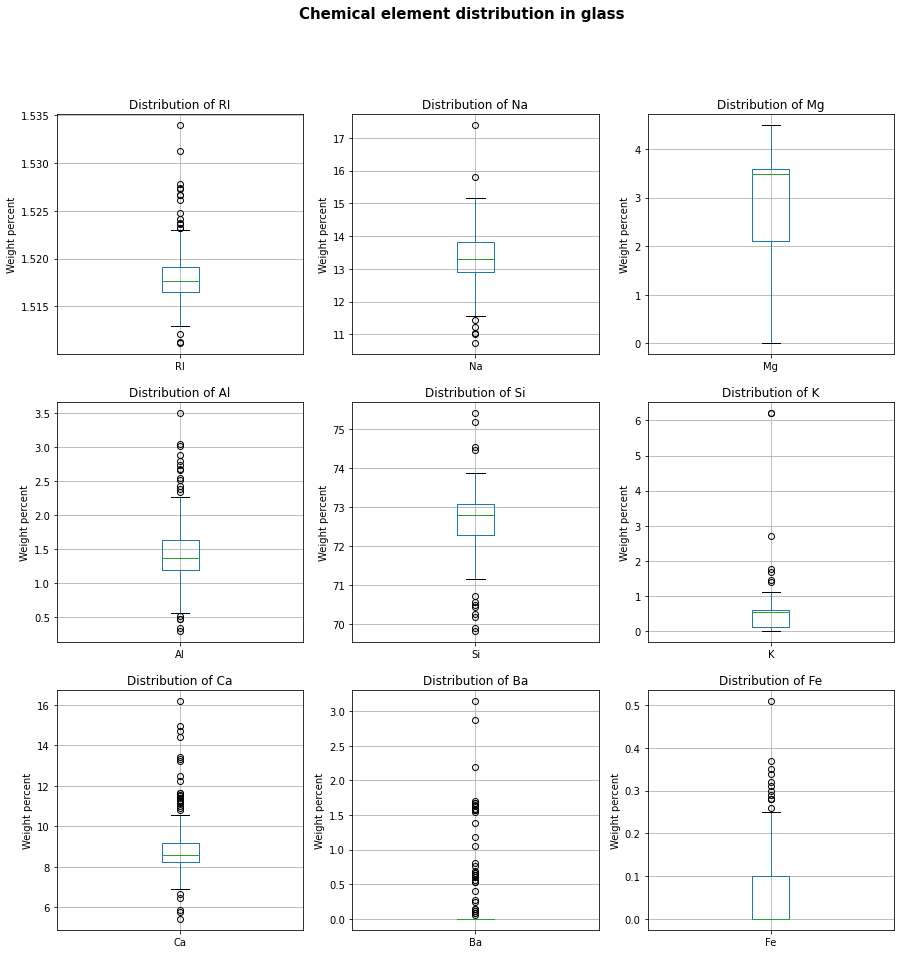

In [12]:
# Boxplot for each column
fig, axes = plt.subplots(3,3, figsize=(15,15))

for i in range(len(headers) - 1):
    ax = axes.flatten()[i]
    glass_df.boxplot(column=headers[i], ax=ax)
    ax.set_title("Distribution of " + headers[i])
    ax.set_ylabel('Weight percent')
fig.suptitle('Chemical element distribution in glass', fontsize=15, fontweight='bold')

In [13]:
def detect_outliers(df):
    """
    Return the list of indices of the observations containing more than 2 outliers
    Parameter: dataframe
    Return: list of indices
    """
    outlier_list = []
    for col in df.columns:
        # Calculate the interquartile range
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        # Identify outliers
        outlier_step = 1.5 * IQR
        outliers = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_list.extend(outliers)
        
    # Count the occurence of the index
    idx_counts = {}
    for i in outlier_list:
        if i in idx_counts:
            idx_counts[i] += 1
        else:
            idx_counts[i] = 1
    # Filter indices with more than 2 outliers
    multiple_outliers = [i for i, count in idx_counts.items() if count > 2]
        
    return multiple_outliers

print(f'The dataset contains {len(detect_outliers(glass_df[elements]))} observations with more than 2 outliers')        

The dataset contains 10 observations with more than 2 outliers


We remove the outliers from the dataset. This left us remaining 204 observations

In [14]:
outliers = detect_outliers(glass_df[elements])
glass_df = glass_df.drop(outliers)

In [15]:
glass_df.reset_index(drop=True, inplace=True)

# Data exploration

## Single feature

In [16]:
glass_df[glass_df.columns.difference(['Type'])].describe().round(2)

,Al,Ba,Ca,Fe,K,Mg,Na,RI,Si
count,204.00,204.00,204.00,204.00,204.00,204.00,204.00,204.00,204.00
mean,1.41,0.12,9.01,0.06,0.42,2.76,13.39,1.52,72.70
std,0.45,0.36,1.30,0.10,0.31,1.40,0.73,0.00,0.66
min,0.29,0.00,7.08,0.00,0.00,0.00,11.02,1.51,70.16
25%,1.19,0.00,8.28,0.00,0.12,2.36,12.90,1.52,72.34
50%,1.36,0.00,8.61,0.00,0.55,3.49,13.30,1.52,72.82
75%,1.59,0.00,9.19,0.10,0.60,3.61,13.79,1.52,73.10
max,2.88,1.71,16.19,0.51,2.70,4.49,15.15,1.53,75.18


Measures of central tendency:
- Si is the primary element in the glass composition, average accounting for 72.65%.
- The second and third element in glass concentration are Na and Ca, for the figures of 13% and 9% respectively. 
- Compared to Si, other elements have marginal content, with below 5% in average. 

Variability: The variability of the elements will be assessed by the coefficient of variation. By that, they are divided into two groups of low and high variability. This division supports the exploration in the following stage.

In [17]:
# Define the coefficient of variation 
def calc_cov(data, element):
    std = data[element].std()
    mean = data[element].mean()
    return ((std/mean) * 100)

threshold = 50
# Divide the chemical elements into two groups based on variability
high_var = dict()
low_var = dict()
for e in elements:
    cov = calc_cov(glass_df, e)
    if (cov > threshold):
        high_var[e] = cov
    else:
        low_var[e] = cov
print('---LOW VARIABILITY GROUP---')
for k,v in low_var.items():
    print(k + ': %.2f' %(v))
print('---HIGH VARIABILITY GROUP---')
for k,v in high_var.items():
    print(k + ': %.2f' %(v))

---LOW VARIABILITY GROUP---
Na: 5.42
Al: 31.78
Si: 0.91
Ca: 14.41
---HIGH VARIABILITY GROUP---
Mg: 50.65
K: 72.64
Ba: 296.73
Fe: 168.92


Text(0.5, 0.98, 'Chemical element distribution in glass')

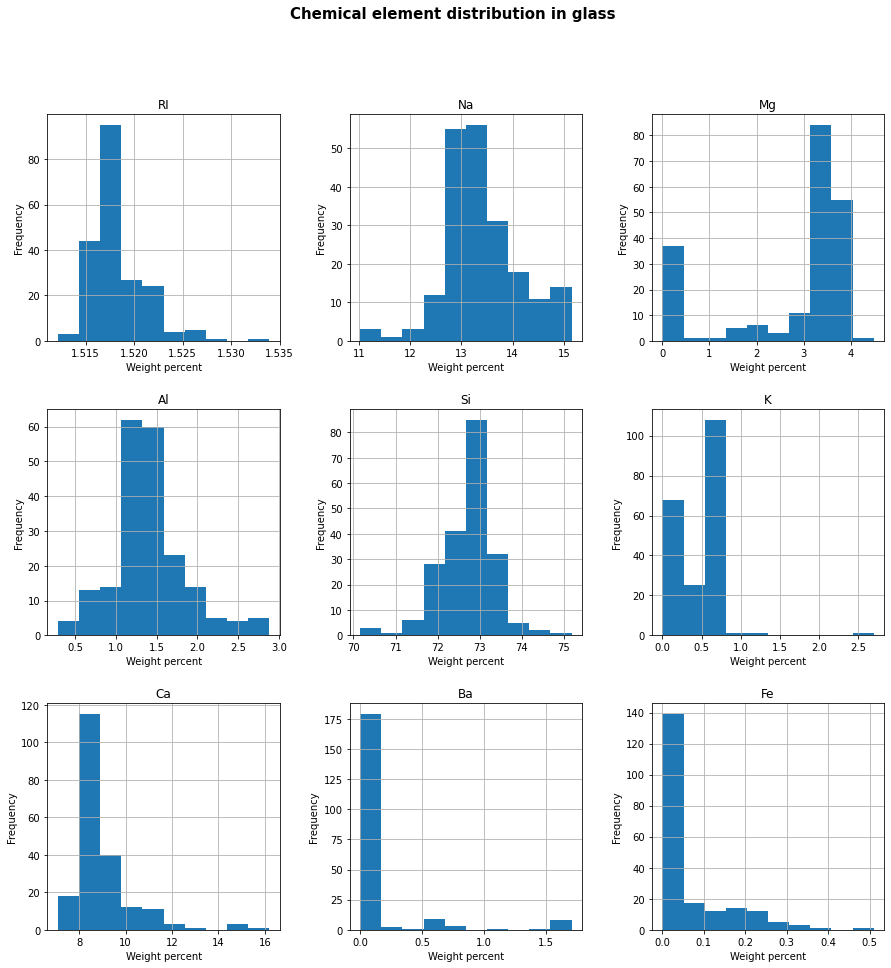

In [18]:
# Plot histogram for each column
fig, axes = plt.subplots(3,3, figsize=(15,15))

for i in range(len(headers) - 1):
    ax = axes.flatten()[i]
    glass_df.hist(column=headers[i], ax=ax)
    ax.set_title(headers[i])
    ax.set_xlabel('Weight percent')
    ax.set_ylabel('Frequency')
fig.suptitle('Chemical element distribution in glass', fontsize=15, fontweight='bold')

### Hypothese: Low variability group's distribution is consistent among glass types

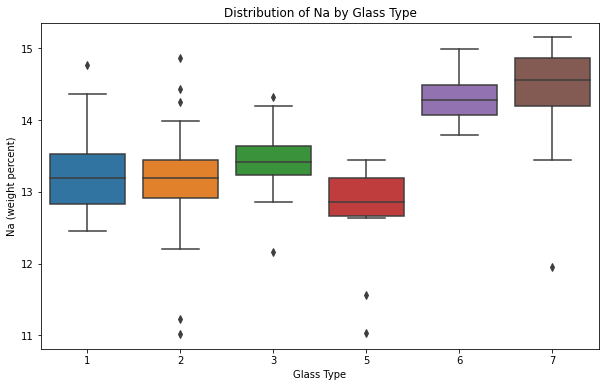

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Na', data=glass_df)
plt.title('Distribution of Na by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Na (weight percent)')
plt.show()

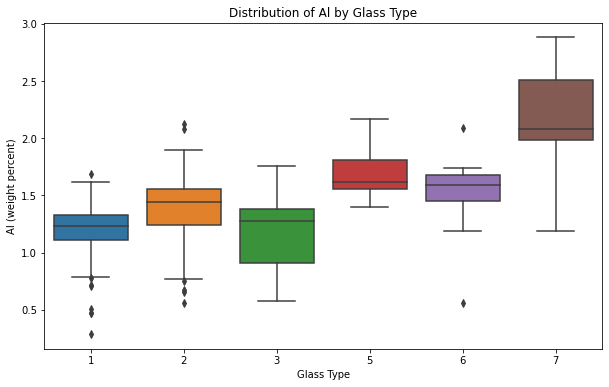

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Al', data=glass_df)
plt.title('Distribution of Al by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Al (weight percent)')
plt.show()

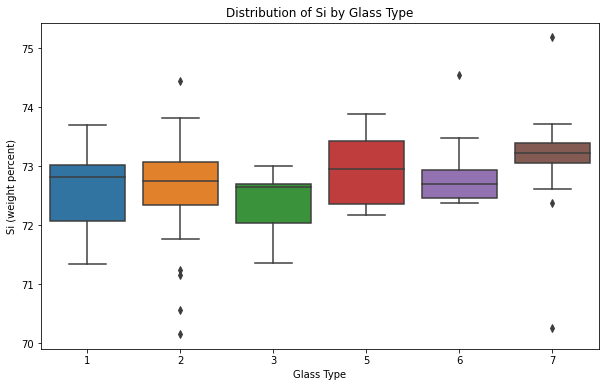

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Si', data=glass_df)
plt.title('Distribution of Si by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Si (weight percent)')
plt.show()

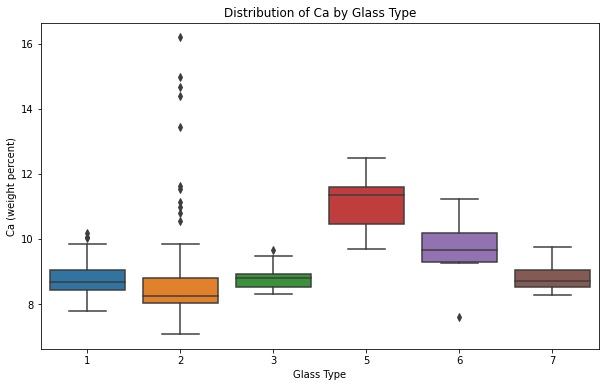

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Ca', data=glass_df)
plt.title('Distribution of Ca by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Ca (weight percent)')
plt.show()

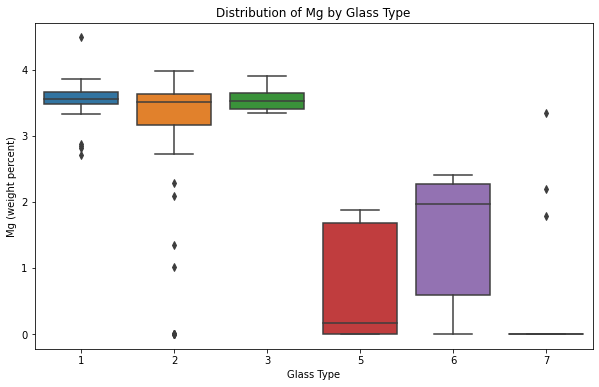

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Mg', data=glass_df)
plt.title('Distribution of Mg by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Mg (weight percent)')
plt.show()

### Hypothese: High variability group's distribution is significantly different among glass types

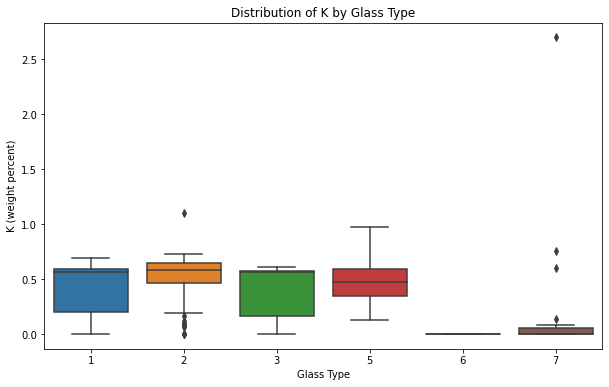

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='K', data=glass_df)
plt.title('Distribution of K by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('K (weight percent)')
plt.show()

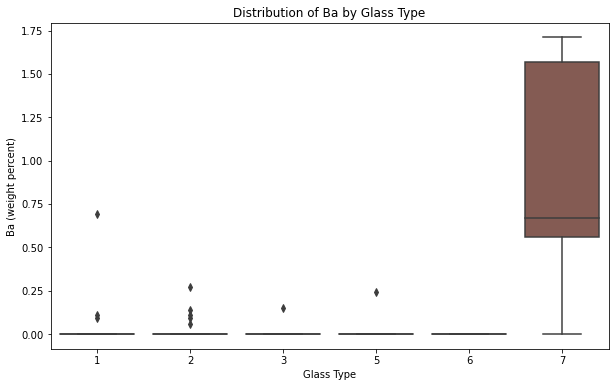

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Ba', data=glass_df)
plt.title('Distribution of Ba by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Ba (weight percent)')
plt.show()

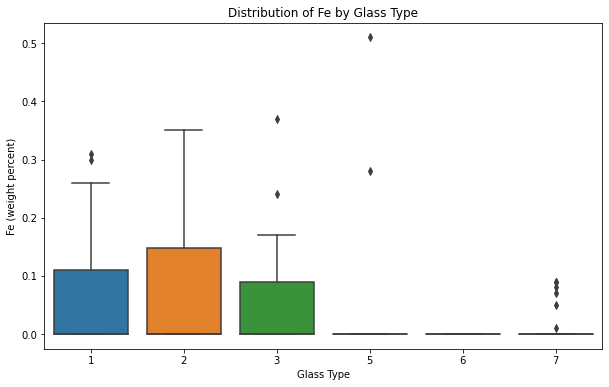

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Fe', data=glass_df)
plt.title('Distribution of Fe by Glass Type')
plt.xlabel('Glass Type')
plt.ylabel('Fe (weight percent)')
plt.show()

## Relationship between features

### Find the potential correlation among features

We can start by spotting any strong correlation between the chemical elements, or a chemical elements vs refractive index.
- Positive correlation:
    - Ri vs Ca
    - Ba vs Na
    - Ba vs Al
    - K vs Mg 
- Negative correlation:
    - Ri vs Si
    - Ri vs Al
    - Ba vs Mg
    - Mg vs Ca
    - Mg vs Al
    - K vs Na 


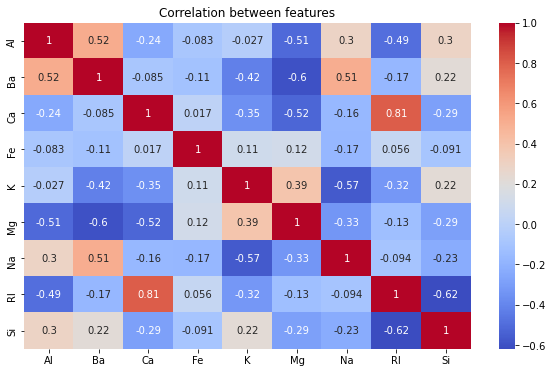

In [27]:
corr_matrix = glass_df[glass_df.columns.difference(['Type'])].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

### Hypothese 1: Higher Ca results in higher RI

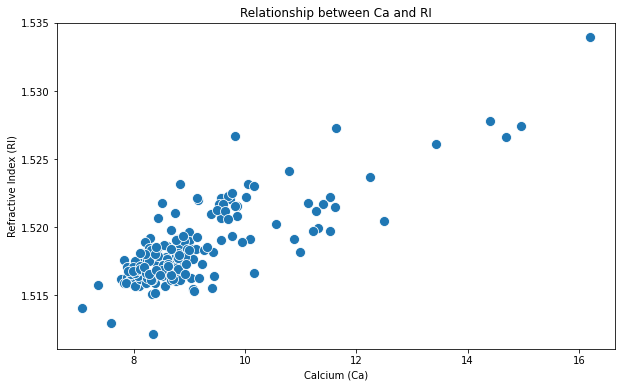

In [28]:
# Scatter plot of Ca vs RI
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ca', y='RI', data=glass_df, palette='Set1', s=100)
plt.title('Relationship between Ca and RI')
plt.xlabel('Calcium (Ca)')
plt.ylabel('Refractive Index (RI)')
plt.show()

It can be seen that higher Ca content is associated with higher RI. This indicates that Ca is likely to be a predictor for RI. By that, we can consider remove one of the attributes in the feature selection stage, so as to simplify the dataset and potential enhance the model performance.

### Hypothesis 2: Ba has a postive linear correlation with Na

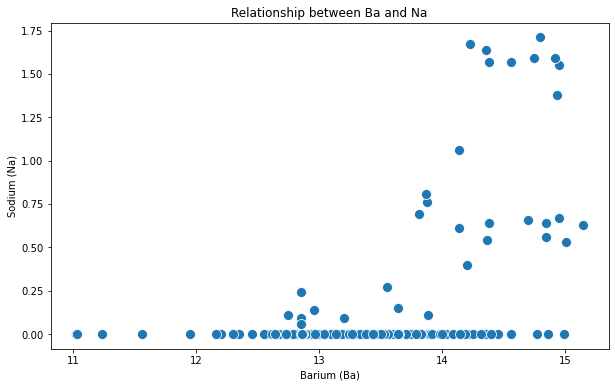

In [29]:
# Scatter plot of Ba vs Na
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Na', y='Ba', data=glass_df, s=100)
plt.title('Relationship between Ba and Na')
plt.xlabel('Barium (Ba)')
plt.ylabel('Sodium (Na)')
plt.show()

### Hypothese 3: Higher level of Ba is associated with higher level of Al

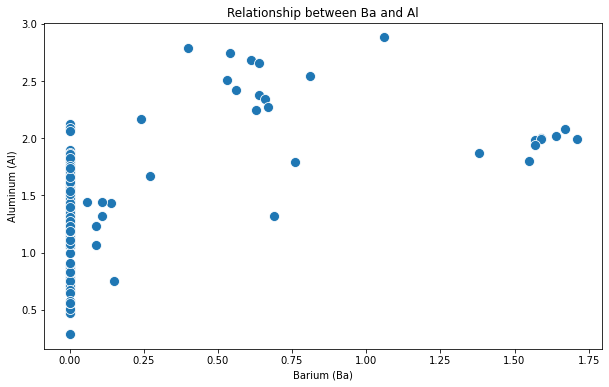

In [30]:
# Scatter plot of Ba vs Al
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ba', y='Al', data=glass_df, s=100)
plt.title('Relationship between Ba and Al')
plt.xlabel('Barium (Ba)')
plt.ylabel('Aluminum (Al)')
plt.show()

### Hypothese 4:  High level of K is related to high level of Mg 

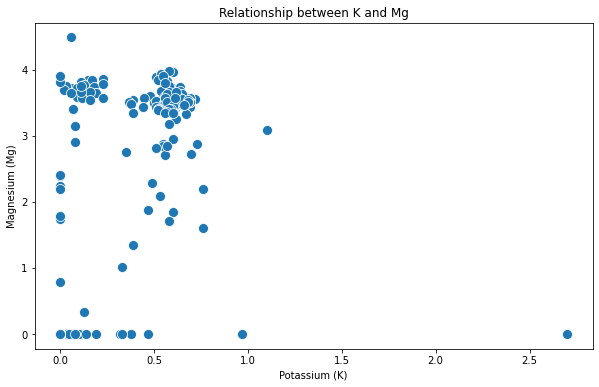

In [31]:
# Scatter plot of K vs Mg
plt.figure(figsize=(10, 6))
sns.scatterplot(x='K', y='Mg', data=glass_df, s=100)
plt.title('Relationship between K and Mg')
plt.xlabel('Potassium (K)')
plt.ylabel('Magnesium (Mg)')
plt.show()

### Hypothese 5: Lower level of Si results in higher rate of RI

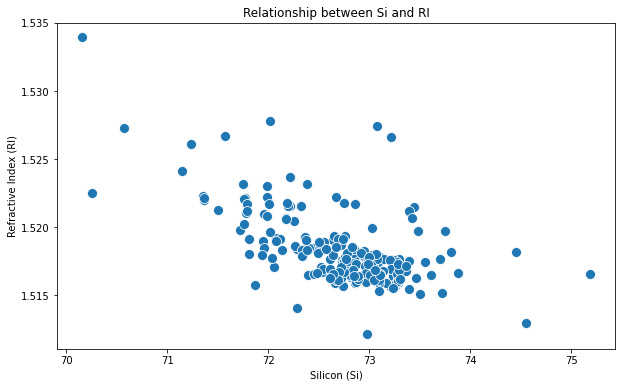

In [32]:
# Scatter plot of Si vs RI
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Si', y='RI', data=glass_df, s=100)
plt.title('Relationship between Si and RI')
plt.xlabel('Silicon (Si)')
plt.ylabel('Refractive Index (RI)')
plt.show()

### Hypothese 6: Low content of Al is associated with high rate of RI

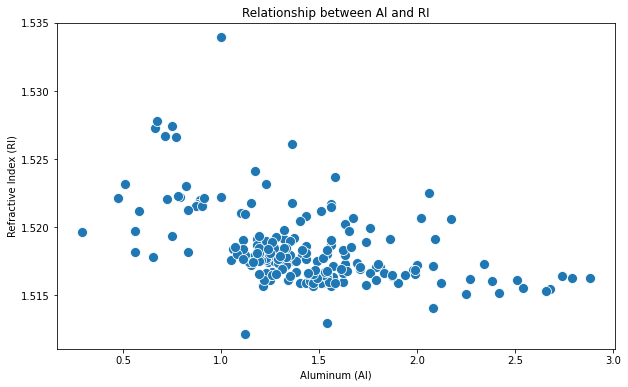

In [33]:
# Scatter plot of Al vs RI
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Al', y='RI', data=glass_df, s=100)
plt.title('Relationship between Al and RI')
plt.xlabel('Aluminum (Al)')
plt.ylabel('Refractive Index (RI)')
plt.show()

### Hypothese 7: Ba and Mg have negative linear relationship 

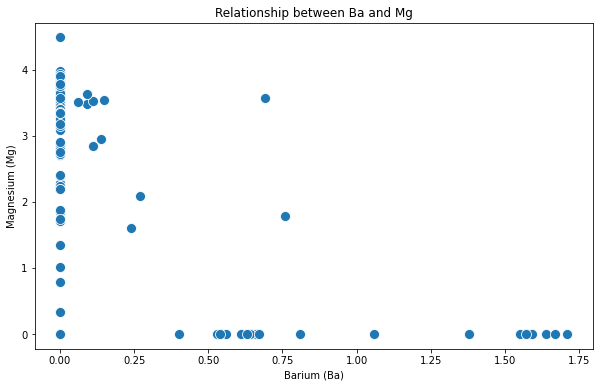

In [34]:
# Scatter plot of Ba vs Mg
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ba', y='Mg', data=glass_df, s=100)
plt.title('Relationship between Ba and Mg')
plt.xlabel('Barium (Ba)')
plt.ylabel('Magnesium (Mg)')
plt.show()

### Hypothese 8: Higher level of Mg, lower level of Ca

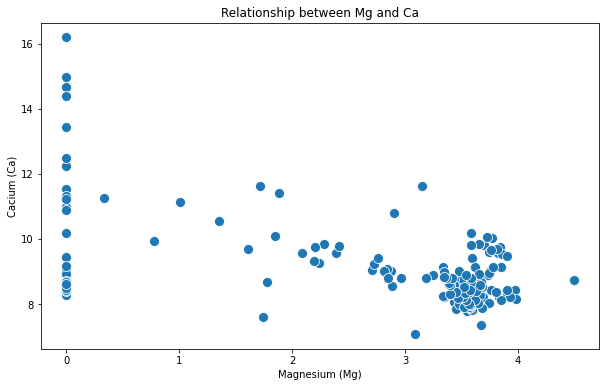

In [35]:
# Scatter plot of Mg vs Ca
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mg', y='Ca', data=glass_df, s=100)
plt.title('Relationship between Mg and Ca')
plt.xlabel('Magnesium (Mg)')
plt.ylabel('Cacium (Ca)')
plt.show()

### Hypothese 9: High content in Al is associated with low content in Mg 

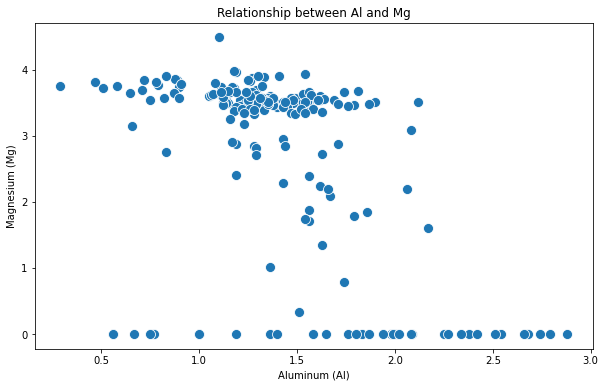

In [36]:
# Scatter plot of Al vs Mg
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Al', y='Mg', data=glass_df, s=100)
plt.title('Relationship between Al and Mg')
plt.xlabel('Aluminum (Al)')
plt.ylabel('Magnesium (Mg)')
plt.show()

### Hypothese 10: K has a negative linear relationship with Na

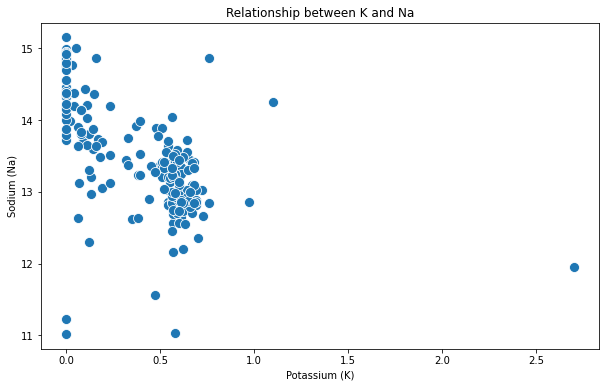

In [37]:
# Scatter plot of K vs Na
plt.figure(figsize=(10, 6))
sns.scatterplot(x='K', y='Na', data=glass_df, s=100)
plt.title('Relationship between K and Na')
plt.xlabel('Potassium (K)')
plt.ylabel('Sodium (Na)')
plt.show()

# Data modelling

In [38]:
# Select feature
X = glass_df.drop('Type', axis=1, inplace=False)
X = X.drop('RI', axis=1)
X.head(5)

,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [39]:
n = glass_df['Fe'].count()

In [40]:
n

204

## Data standardization

In [41]:
def standard_scale(df):
    """
    Apply standard scaling to the dataset
    :param data frame
    :return data frame with scaled data 
    """
    scaled = pd.DataFrame()
    for col in df.columns:
        avg = df[col].mean()
        std = df[col].std()
        n = df[col].count()
        scaled[col] = df[col].apply(lambda x: (x-avg)/(std))
    return scaled

In [42]:
X_scaled = standard_scale(X)
X_scaled

,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,0.344820,1.234853,-0.696416,-1.400536,-1.180531,-0.198438,-0.337009,-0.591993
1,0.689235,0.598717,-0.117180,0.040525,0.191896,-0.907286,-0.337009,-0.591993
2,0.193277,0.562979,0.283830,0.434921,-0.102195,-0.945811,-0.337009,-0.591993
3,-0.247573,0.663045,-0.273128,-0.141504,0.485988,-0.606796,-0.337009,-0.591993
4,-0.164914,0.613012,-0.384520,0.571442,0.420634,-0.722369,-0.337009,-0.591993
...,...,...,...,...,...,...,...,...
199,1.033650,-1.974419,3.269126,-0.141504,-1.115178,0.132871,2.609811,-0.591993
200,2.108224,-1.974419,1.286355,0.541104,-1.376592,-0.468109,4.083221,-0.591993
201,1.336735,-1.974419,1.353190,1.087191,-1.376592,-0.437289,4.222222,-0.591993
202,1.364288,-1.974419,1.174963,1.375403,-1.376592,-0.406470,4.027621,-0.591993


## K-means

In [43]:
glass_df.Type.value_counts()

2    74
1    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

### Model 1: k = 6

In [44]:
num_clusters = 6
km = KMeans(n_clusters=6, random_state=42)
km = km.fit(X_scaled)
clusters = km.labels_

In [45]:
km_result = X_scaled
km_result['cluster'] = clusters
km_result['target'] = glass_df['Type'].astype(int)
km_result['count'] = "count"
km_final = km_result[["cluster", "target", "count"]].groupby(["cluster","target"]).agg("count")

In [46]:
#  Create a confusion matrix 
km_confusion_matrix = km_final.reset_index().pivot(index='target', columns='cluster', values='count').fillna(0)

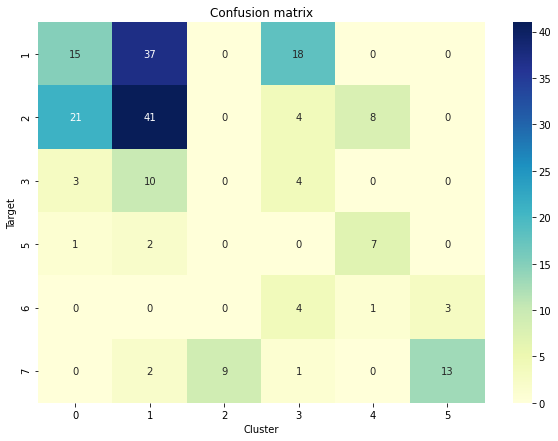

In [47]:
plt.figure(figsize=(10,7))
sns.heatmap(km_confusion_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Cluster')
plt.ylabel('Target')
plt.show()

In [48]:
def purity_score(matrix):
    # Find the most frequent true class labels for each cluster
    cluster_sum = np.sum(matrix, axis=1)
    total_samples = np.sum(cluster_sum)
    
    # Calculate purity
    purity = np.sum(np.max(matrix, axis=1)) / total_samples
    return purity

purity = purity_score(km_confusion_matrix)
print(f'Purity score: {purity:.2f}')

# Calculate the most frequent true label for each cluster
most_frequent_labels = km_result.groupby('cluster')['target'].agg(lambda x: x.value_counts().index[0])

# Map clusters to predicted labels
predicted_labels = km_result['cluster'].map(most_frequent_labels)

# Calculate accuracy score
accuracy = accuracy_score(glass_df['Type'].values, predicted_labels)
print(f'Accuracy Score: {accuracy:.2f}')

Purity score: 0.55
Accuracy Score: 0.54


In [49]:
most_frequent_labels

cluster
0    2
1    2
2    7
3    1
4    2
5    7
Name: target, dtype: int32

<AxesSubplot:xlabel='Na', ylabel='Al'>

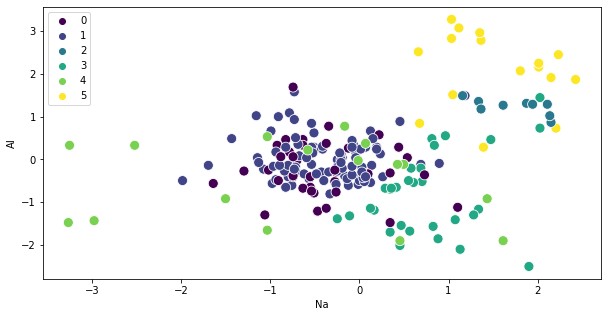

In [50]:
# Visualization 
plt.figure(figsize=(10,5))
sns.scatterplot(x=km_result.iloc[:,0], y=km_result.iloc[:,2], hue=clusters, palette='viridis', s=100)

### Find the optimal k clusters

In [51]:
X_scaled = standard_scale(X)
X_scaled

,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,0.344820,1.234853,-0.696416,-1.400536,-1.180531,-0.198438,-0.337009,-0.591993
1,0.689235,0.598717,-0.117180,0.040525,0.191896,-0.907286,-0.337009,-0.591993
2,0.193277,0.562979,0.283830,0.434921,-0.102195,-0.945811,-0.337009,-0.591993
3,-0.247573,0.663045,-0.273128,-0.141504,0.485988,-0.606796,-0.337009,-0.591993
4,-0.164914,0.613012,-0.384520,0.571442,0.420634,-0.722369,-0.337009,-0.591993
...,...,...,...,...,...,...,...,...
199,1.033650,-1.974419,3.269126,-0.141504,-1.115178,0.132871,2.609811,-0.591993
200,2.108224,-1.974419,1.286355,0.541104,-1.376592,-0.468109,4.083221,-0.591993
201,1.336735,-1.974419,1.353190,1.087191,-1.376592,-0.437289,4.222222,-0.591993
202,1.364288,-1.974419,1.174963,1.375403,-1.376592,-0.406470,4.027621,-0.591993


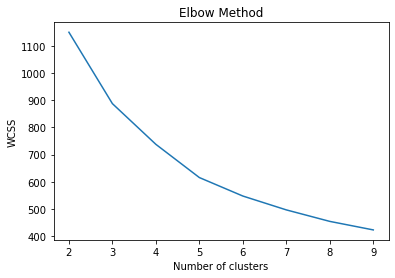

In [52]:
data = glass_df.drop('Type', axis=1, inplace=False)
data = data.drop('RI', axis=1)
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=10, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Model 2: k = 3

In [53]:
X_scaled = standard_scale(X)

In [54]:
num_clusters = 3
km2 = KMeans(n_clusters=num_clusters, random_state=42)
km2 = km2.fit(X_scaled)
clusters = km2.labels_

In [55]:
km2_result = X_scaled
km2_result['cluster'] = clusters
km2_result['target'] = glass_df['Type'].astype(int)
km2_result['count'] = "count"
km2_final = km2_result[["cluster", "target", "count"]].groupby(["cluster","target"]).agg("count")

In [56]:
#  Create a confusion matrix 
km2_confusion_matrix = km2_final.reset_index().pivot(index='target', columns='cluster', values='count').fillna(0)

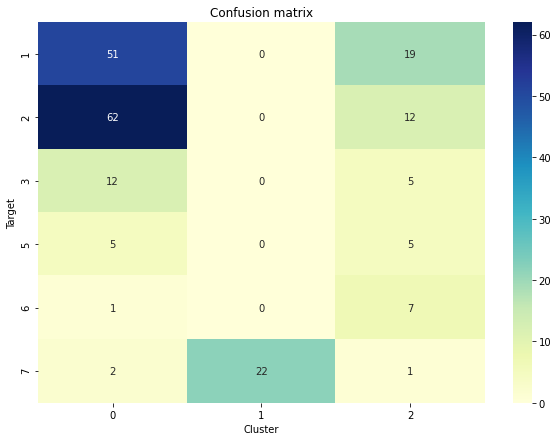

In [57]:
plt.figure(figsize=(10,7))
sns.heatmap(km2_confusion_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Cluster')
plt.ylabel('Target')
plt.show()

<AxesSubplot:xlabel='Na', ylabel='Al'>

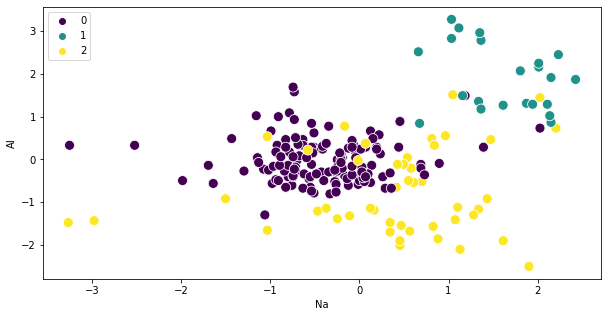

In [58]:
# Visualization 
plt.figure(figsize=(10,5))
sns.scatterplot(x=km2_result.iloc[:,0], y=km2_result.iloc[:,2], hue=clusters, palette='viridis', s=100)

In [59]:
# Evaluation 
purity = purity_score(km2_confusion_matrix)
print(f'Purity score: {purity:.2f}')
# Accuracy score
most_frequent_labels = km2_result.groupby('cluster')['target'].agg(lambda x: x.value_counts().index[0])
predicted_labels = km2_result['cluster'].map(most_frequent_labels)
accuracy = accuracy_score(glass_df['Type'].values, predicted_labels)
print(f'Accuracy Score: {accuracy:.2f}')

Purity score: 0.78
Accuracy Score: 0.50


### Model 3: k = 5

In [60]:
X_scaled = standard_scale(X)

In [61]:
num_clusters = 5
km3 = KMeans(n_clusters=num_clusters, random_state=42)
km3 = km3.fit(X_scaled)
clusters = km3.labels_

In [62]:
km3_result = X_scaled
km3_result['cluster'] = clusters
km3_result['target'] = glass_df['Type'].astype(int)
km3_result['count'] = "count"
km3_final = km3_result[["cluster", "target", "count"]].groupby(["cluster","target"]).agg("count")

In [63]:
#  Create a confusion matrix 
km3_confusion_matrix = km3_final.reset_index().pivot(index='target', columns='cluster', values='count').fillna(0)

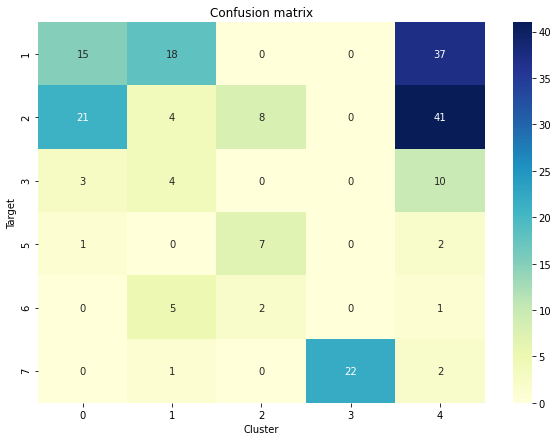

In [64]:
plt.figure(figsize=(10,7))
sns.heatmap(km3_confusion_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Cluster')
plt.ylabel('Target')
plt.show()

<AxesSubplot:xlabel='Na', ylabel='Al'>

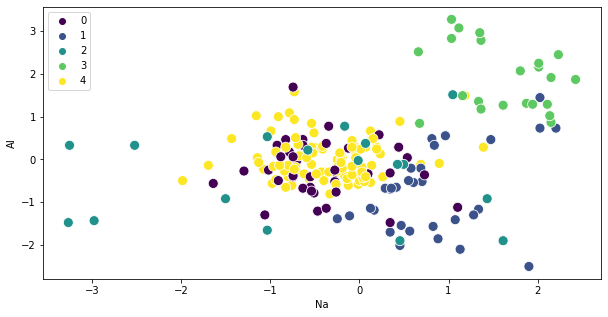

In [65]:
# Visualization 
plt.figure(figsize=(10,5))
sns.scatterplot(x=km3_result.iloc[:,0], y=km3_result.iloc[:,2], hue=clusters, palette='viridis', s=100)

In [66]:
# Evaluation 
purity = purity_score(km3_confusion_matrix)
print(f'Purity score: {purity:.2f}')
# Accuracy score
most_frequent_labels = km3_result.groupby('cluster')['target'].agg(lambda x: x.value_counts().index[0])
predicted_labels = km3_result['cluster'].map(most_frequent_labels)
accuracy = accuracy_score(glass_df['Type'].values, predicted_labels)
print(f'Accuracy Score: {accuracy:.2f}')

Purity score: 0.60
Accuracy Score: 0.54


## DBSCAN

### Model 1: MinPts = 9

In [67]:
X_scaled = standard_scale(X)

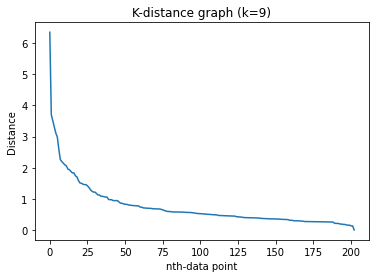

In [68]:
nbrs = NearestNeighbors().fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled, 9)
k_dis = distances[:, 1]
k_dis.sort()
k_dis = k_dis[list(range(len(k_dis) - 1, 0, -1))]
plt.plot(k_dis)
plt.title('K-distance graph (k=9)')
plt.xlabel('nth-data point')
plt.ylabel('Distance')
plt.show()

In [69]:
dbscan = DBSCAN(eps=1.5, min_samples=9)
dbscan = dbscan.fit(X_scaled)
dbscan_results = X_scaled
dbscan_results['cluster'] = dbscan.labels_
dbscan_results['target'] = glass_df['Type']
dbscan_results['count'] = "count"
dbscan_results.head(10)

,Na,Mg,Al,Si,K,Ca,Ba,Fe,cluster,target,count
0,0.344820,1.234853,-0.696416,-1.400536,-1.180531,-0.198438,-0.337009,-0.591993,0,1,count
1,0.689235,0.598717,-0.117180,0.040525,0.191896,-0.907286,-0.337009,-0.591993,0,1,count
2,0.193277,0.562979,0.283830,0.434921,-0.102195,-0.945811,-0.337009,-0.591993,0,1,count
3,-0.247573,0.663045,-0.273128,-0.141504,0.485988,-0.606796,-0.337009,-0.591993,0,1,count
4,-0.164914,0.613012,-0.384520,0.571442,0.420634,-0.722369,-0.337009,-0.591993,0,1,count
5,-0.826190,0.605864,0.462057,0.404583,0.714726,-0.722369,-0.337009,2.119519,0,1,count
6,-0.123584,0.598717,-0.607303,0.586612,0.518665,-0.645321,-0.337009,-0.591993,0,1,count
7,-0.330233,0.605864,-0.807808,0.814148,0.485988,-0.591387,-0.337009,-0.591993,0,1,count
8,0.895884,0.584421,-0.094901,-0.945464,0.453311,-0.545157,-0.337009,-0.591993,0,1,count
9,-0.536882,0.598717,-0.117180,0.434921,0.485988,-0.468109,-0.337009,0.555185,0,1,count


In [70]:
dbscan_final = dbscan_results[['cluster', 'target', 'count']].groupby(['cluster', 'target']).agg('count')
dbscan_final

count
cluster target       
-1      1           1
        2          16
        3           2
        5           9
        6           6
        7           4
 0      1          69
        2          58
        3          15
        5           1
        6           2
        7           1
 1      7          11
 2      7           9

Text(0.5, 1.0, 'DBSCAN result (MinPts = 9)')

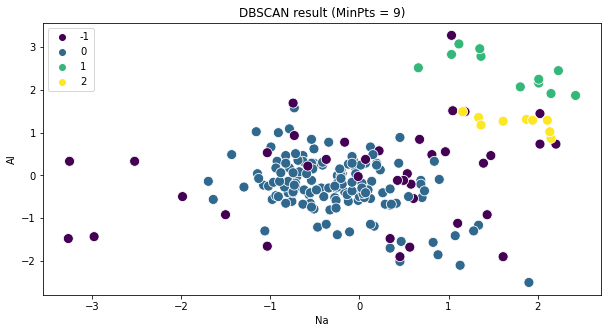

In [71]:
# Visualization 
plt.figure(figsize=(10,5))
sns.scatterplot(x=dbscan_results.iloc[:,0], y=dbscan_results.iloc[:,2], hue=dbscan.labels_, palette='viridis', s=100)
plt.title('DBSCAN result (MinPts = 9)')

In [72]:
y=glass_df['Type'].values
most_frequent_labels = dbscan_results.groupby('cluster')['target'].agg(lambda x: x.value_counts().index[0])

# Handle noise points labeled as -1 by DBSCAN
most_frequent_labels = most_frequent_labels.to_dict()
most_frequent_labels[-1] = -1  # Assuming noise points get a dummy label -1
print("Most frequent labels: ")
print(most_frequent_labels)

# Map each cluster label to the most frequent true label
predicted_labels = dbscan_results['cluster'].map(most_frequent_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate purity score
def purity_score(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)

purity = purity_score(glass_df['Type'].values, predicted_labels)
print(f'Purity Score: {purity:.2f}')

accuracy = accuracy_score(glass_df['Type'].values, predicted_labels)
print(f'Accuracy Score: {accuracy:.2f}')

Most frequent labels: 
{-1: -1, 0: 1, 1: 7, 2: 7}
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [ 1 69  0  0  0  0  0]
 [16 58  0  0  0  0  0]
 [ 2 15  0  0  0  0  0]
 [ 9  1  0  0  0  0  0]
 [ 6  2  0  0  0  0  0]
 [ 4  1  0  0  0  0 20]]
Purity Score: 0.51
Accuracy Score: 0.44


### Model 2: MinPts = 16

In [73]:
X_scaled = standard_scale(X)

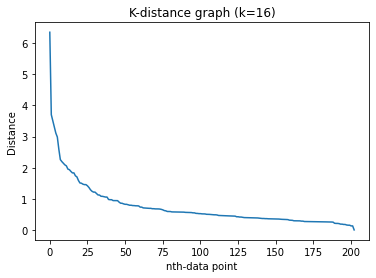

In [74]:
nbrs = NearestNeighbors().fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled, 16)
k_dis = distances[:, 1]
k_dis.sort()
k_dis = k_dis[list(range(len(k_dis) - 1, 0, -1))]
plt.plot(k_dis)
plt.title('K-distance graph (k=16)')
plt.xlabel('nth-data point')
plt.ylabel('Distance')
plt.show()

In [75]:
dbscan2 = DBSCAN(eps=1.5, min_samples=16)
dbscan2 = dbscan2.fit(X_scaled)
dbscan2_results = X_scaled
dbscan2_results['cluster'] = dbscan2.labels_
dbscan2_results['target'] = glass_df['Type']
dbscan2_results['count'] = "count"
dbscan2_results.head(10)

,Na,Mg,Al,Si,K,Ca,Ba,Fe,cluster,target,count
0,0.344820,1.234853,-0.696416,-1.400536,-1.180531,-0.198438,-0.337009,-0.591993,0,1,count
1,0.689235,0.598717,-0.117180,0.040525,0.191896,-0.907286,-0.337009,-0.591993,0,1,count
2,0.193277,0.562979,0.283830,0.434921,-0.102195,-0.945811,-0.337009,-0.591993,0,1,count
3,-0.247573,0.663045,-0.273128,-0.141504,0.485988,-0.606796,-0.337009,-0.591993,0,1,count
4,-0.164914,0.613012,-0.384520,0.571442,0.420634,-0.722369,-0.337009,-0.591993,0,1,count
5,-0.826190,0.605864,0.462057,0.404583,0.714726,-0.722369,-0.337009,2.119519,0,1,count
6,-0.123584,0.598717,-0.607303,0.586612,0.518665,-0.645321,-0.337009,-0.591993,0,1,count
7,-0.330233,0.605864,-0.807808,0.814148,0.485988,-0.591387,-0.337009,-0.591993,0,1,count
8,0.895884,0.584421,-0.094901,-0.945464,0.453311,-0.545157,-0.337009,-0.591993,0,1,count
9,-0.536882,0.598717,-0.117180,0.434921,0.485988,-0.468109,-0.337009,0.555185,0,1,count


In [76]:
dbscan2_final = dbscan2_results[['cluster', 'target', 'count']].groupby(['cluster', 'target']).agg('count')
dbscan2_final

count
cluster target       
-1      1          15
        2          18
        3           4
        5           9
        6           7
        7          24
 0      1          55
        2          56
        3          13
        5           1
        6           1
        7           1

Text(0.5, 1.0, 'DBSCAN result (MinPts = 16)')

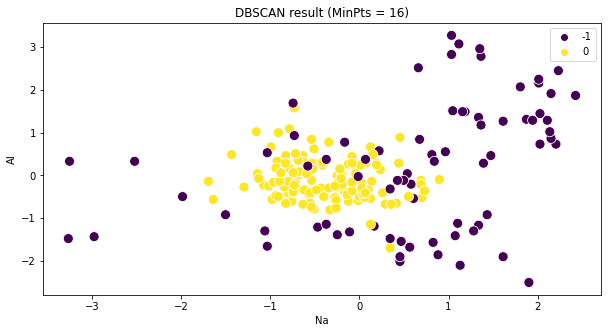

In [77]:
# Visualization 
plt.figure(figsize=(10,5))
sns.scatterplot(x=dbscan2_results.iloc[:,0], y=dbscan2_results.iloc[:,2], hue=dbscan2.labels_, palette='viridis', s=100)
plt.title('DBSCAN result (MinPts = 16)')

In [78]:
y=glass_df['Type'].values
most_frequent_labels = dbscan2_results.groupby('cluster')['target'].agg(lambda x: x.value_counts().index[0])

# Handle noise points labeled as -1 by DBSCAN
most_frequent_labels = most_frequent_labels.to_dict()
most_frequent_labels[-1] = -1  # Assuming noise points get a dummy label -1
print("Most frequent labels: ")
print(most_frequent_labels)

# Map each cluster label to the most frequent true label
predicted_labels = dbscan2_results['cluster'].map(most_frequent_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

purity = purity_score(glass_df['Type'].values, predicted_labels)
print(f'Purity Score: {purity:.2f}')

accuracy = accuracy_score(glass_df['Type'].values, predicted_labels)
print(f'Accuracy Score: {accuracy:.2f}')

Most frequent labels: 
{-1: -1, 0: 2}
Confusion Matrix:
[[ 0  0  0  0  0  0  0]
 [15  0 55  0  0  0  0]
 [18  0 56  0  0  0  0]
 [ 4  0 13  0  0  0  0]
 [ 9  0  1  0  0  0  0]
 [ 7  0  1  0  0  0  0]
 [24  0  1  0  0  0  0]]
Purity Score: 0.39
Accuracy Score: 0.27
